In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, callbacks
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from matplotlib import pyplot as plt
import pandas as pd
import datetime as dt
import os


In [2]:
FEATURES_PATH = "data/my_20_sec_features-100_plus_additional_large-2022_10_17__02_52_37.npy"
LABELS_PATH = "data/my_20_sec_labels-100_plus_additional_large-2022_10_17__02_52_37.npy"
SITES_PATH = "VPN_client_scripts/urls/top_100.csv"
MODEL_NAME = "transformer_test"


# SCALER_MAX = 1294.0
SEED = 42

In [3]:

num_classes = 100
num_layers = 2
d_model = 64
num_heads = 16
dff = 128
dropout_rate = 0.1
input_shape = (200, 150, 2)


- num_classes: The number of output classes for the classification task. In this case, there are 100 different classes that the model should be able to predict.

- num_layers: The number of encoder layers in the transformer architecture. In this example, there are 2 encoder layers stacked on top of each other.

- d_model: The dimension of the model's input and output states. This is the number of units in the model's internal representation at each layer. In this case, it's set to 64.

- num_heads: The number of attention heads in the multi-head attention mechanism. This controls how many different attention weight matrices are computed for each input sequence. In this case, it's set to 16.

- dff: The dimension of the feed-forward network (dense layer) within each transformer layer. This controls the size of the intermediate representation in the feed-forward network. In this example, it's set to 128.

- dropout_rate: The dropout rate used in the transformer architecture. This is the fraction of input units to drop at each update during training. It's a regularization technique to prevent overfitting. In this case, it's set to 0.1 or 10%.

- input_shape: The shape of the input data for the model. In this example, the input shape is set to (200, 150, 2), which means that the input data consists of 200 time steps, each with 150 features, and 2 channels (for example, if you were using two different input sources or modalities).

In [4]:
sites_df = pd.read_csv(SITES_PATH, names=["ranking", "site"])
sites = list(sites_df.site)
sites[:10]

['google.com',
 'youtube.com',
 'facebook.com',
 'baidu.com',
 'instagram.com',
 'yahoo.com',
 'qq.com',
 'wikipedia.org',
 'bing.com',
 'bilibili.com']

In [5]:
with open(FEATURES_PATH, 'rb') as f:
    features = np.load(f)
features.shape

(18937, 200, 150, 2)

In [6]:
with open(LABELS_PATH, 'rb') as f:
    labels = np.load(f)
labels.shape

(18937,)

In [7]:
for i, label in enumerate(labels):
  if label not in sites:
    labels[i] = "Other"

In [8]:
label_binariser = LabelBinarizer()
label_binariser.classes_ = np.load('encoders/classes.npy')
# label_binariser.fit(pd.DataFrame(sites))
labels_encoded = label_binariser.transform(labels)
del(labels)
labels_encoded.shape

(18937, 100)

In [9]:
class PositionalEncoding(layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.position = position
        self.d_model = d_model
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update({
            'position': self.position,
            'd_model': self.d_model,
        })
        return config

    def call(self, inputs):
        return inputs + self.pos_encoding[:, tf.newaxis, :]

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])
        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]




In [10]:
def transformer_encoder(input_shape, num_layers, d_model, num_heads, dff, rate=0.1):
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Conv2D(d_model, (1, input_shape[1]), padding='valid', activation='linear')(inputs)
    x = tf.keras.layers.Reshape((input_shape[0], d_model))(x)
    x = PositionalEncoding(input_shape[0], d_model)(x)

    for _ in range(num_layers):
        attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
        attn_output = layers.Dropout(rate)(attn_output)
        x = layers.LayerNormalization(epsilon=1e-6)(x + attn_output)

        ffn_output = layers.Dense(dff, activation='relu')(x)
        ffn_output = layers.Dense(d_model)(ffn_output)
        ffn_output = layers.Dropout(rate)(ffn_output)
        x = layers.LayerNormalization(epsilon=1e-6)(x + ffn_output)

    return Model(inputs=inputs, outputs=x, name="transformer_encoder")


In [11]:
early_stopping_callback = callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

In [12]:
encoder = transformer_encoder(input_shape, num_layers, d_model, num_heads, dff, dropout_rate)
input_tensor = tf.keras.Input(shape=input_shape)

x = encoder(input_tensor)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=input_tensor, outputs=x)


2023-04-02 15:53:58.253645: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
model = Model(inputs=input_tensor, outputs=x)

learning_rate = 1e-3

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])



In [14]:
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 150, 2)]     0         
                                                                 
 transformer_encoder (Functi  (None, 200, 64)          583488    
 onal)                                                           
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_4 (Dense)             (None, 100)               6500      
                                                                 
Total params: 589,988
Trainable params: 589,988
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
features_train, features_test, labels_train, labels_test = train_test_split(features, labels_encoded,
    test_size=0.25,
    shuffle=True,
    random_state=SEED
)

del(features)

In [16]:
labels_train.shape

(14202, 100)

In [17]:
training_history = model.fit(features_train, labels_train, epochs=50, batch_size=16, shuffle=True, validation_split=0.2, callbacks=[early_stopping_callback])

Epoch 1/50
711/711 [==============================] - 584s 820ms/step - loss: 1.8388 - accuracy: 0.6697 - val_loss: 1.3816 - val_accuracy: 0.6983
Epoch 2/50
711/711 [==============================] - 565s 795ms/step - loss: 1.2419 - accuracy: 0.7012 - val_loss: 1.1002 - val_accuracy: 0.7226
Epoch 3/50
711/711 [==============================] - 583s 819ms/step - loss: 0.9405 - accuracy: 0.7513 - val_loss: 1.0076 - val_accuracy: 0.7247
Epoch 4/50
711/711 [==============================] - 618s 869ms/step - loss: 0.7283 - accuracy: 0.7962 - val_loss: 0.6719 - val_accuracy: 0.8124
Epoch 5/50
711/711 [==============================] - 734s 1s/step - loss: 0.5702 - accuracy: 0.8417 - val_loss: 0.5554 - val_accuracy: 0.8381
Epoch 6/50
711/711 [==============================] - 850s 1s/step - loss: 0.4657 - accuracy: 0.8681 - val_loss: 0.6168 - val_accuracy: 0.8173
Epoch 7/50
711/711 [==============================] - 564s 793ms/step - loss: 0.4111 - accuracy: 0.8796 - val_loss: 0.4187 - val_a

In [18]:
def plot_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(10,5)) 
    (ax1, ax2) = axs
    ax1.plot(history.history['loss'], label='train')
    ax1.plot(history.history['val_loss'], label='validation')

    ax1.legend(loc="upper right")
    ax1.set_xlabel("# of epochs")
    ax1.set_ylabel("loss")

    ax2.plot(history.history['accuracy'], label='train')
    ax2.plot(history.history['val_accuracy'], label='validation')

    ax2.legend(loc="upper right")
    ax2.set_xlabel("# of epochs")
    ax2.set_ylabel("accuracy")

    print("Final training accuracy:", history.history['accuracy'][-1])
    print("Final validation accuracy:", history.history['val_accuracy'][-1])

In [19]:
y_true = np.argmax(labels_test, axis=1)
unique_y = np.unique(y_true)

Final training accuracy: 0.9616230726242065
Final validation accuracy: 0.9137627482414246


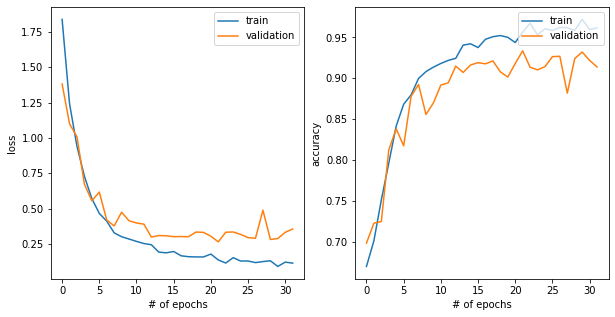

In [20]:
plot_history(training_history)

In [21]:
model_evaluation_history = model.evaluate(features_test, labels_test)
loss, acc = model_evaluation_history
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_datetime = dt.datetime.now()
current_datetime_string = dt.datetime.strftime(current_datetime, date_time_format)
model_file_name =f"{MODEL_NAME}_model_Datetime_{current_datetime_string}__loss_{loss}_acc_{acc}.h5"
model.save(os.path.join("models", model_file_name))

148/148 [==============================] - 100s 675ms/step - loss: 0.2550 - accuracy: 0.9301


In [22]:
def plot_results(model):
    fig, ax = plt.subplots(figsize=(30, 30))
    y_true = np.argmax(labels_test, axis=1)
    predictions =  np.argmax(model.predict(features_test), axis=1)
    cm = confusion_matrix(y_true, predictions, normalize='true')
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=[label_binariser.classes_[x] for x in range(unique_y.min(), len(unique_y))]
        )
    disp.plot(xticks_rotation=270, values_format=".1f", ax=ax)
    plt.show()
    print(classification_report(y_true, predictions))

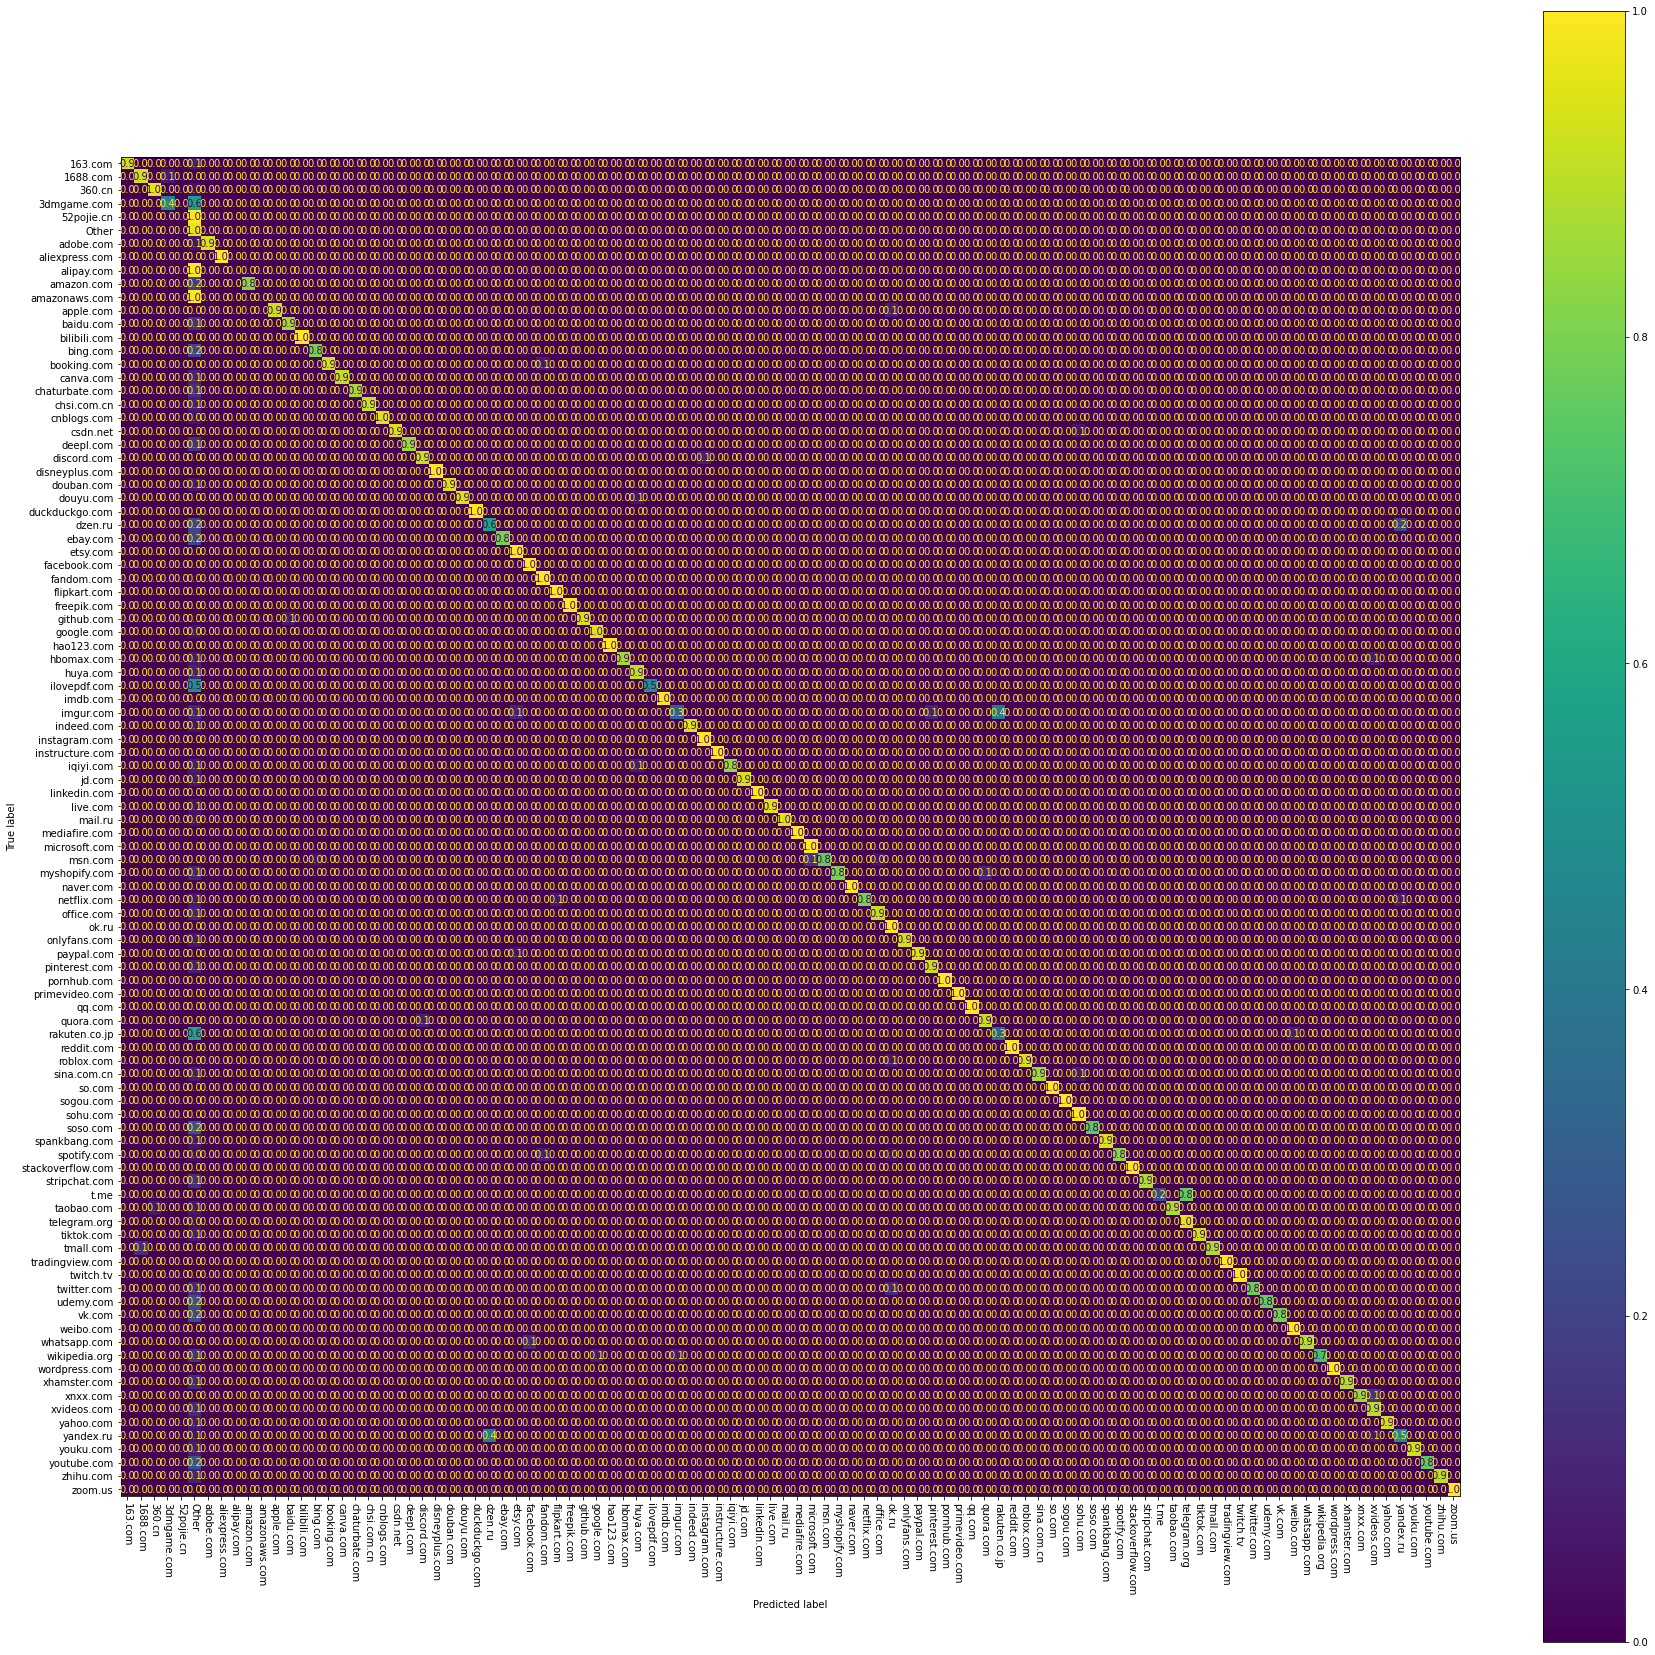

              precision    recall  f1-score   support

           0       0.92      0.92      0.92        13
           1       0.87      0.93      0.90        14
           2       0.92      0.96      0.94        24
           3       0.80      0.44      0.57         9
           4       0.00      0.00      0.00        16
           5       0.95      0.96      0.96      3135
           6       0.63      0.94      0.76        18
           7       1.00      1.00      1.00        15
           8       0.00      0.00      0.00        22
           9       1.00      0.82      0.90        17
          10       0.00      0.00      0.00        15
          11       1.00      0.92      0.96        13
          12       0.93      0.87      0.90        15
          13       1.00      1.00      1.00        15
          14       0.80      0.80      0.80        10
          15       1.00      0.93      0.96        14
          16       1.00      0.91      0.95        11
          17       0.76    

/Users/michaelkearney/.local/share/virtualenvs/UNB_Datasets-qeLdalLc/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/michaelkearney/.local/share/virtualenvs/UNB_Datasets-qeLdalLc/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/michaelkearney/.local/share/virtualenvs/UNB_Datasets-qeLdalLc/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use 

In [23]:
plot_results(model)